<a href="https://colab.research.google.com/github/Ashu-00/Scene-Text-Recognition/blob/main/Inference_for_Scene_Text_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [3]:
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import time
import cv2

In [53]:
img=cv2.imread("/content/drive/MyDrive/EAST Text Detection/det4.jpg")

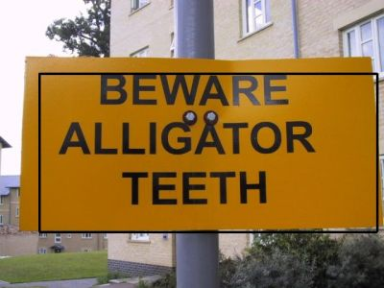

In [54]:

(oH,oW)=img.shape[:2]
reqht=oH-(oH %32)
reqwt=oW-(oW %32)


image = cv2.resize(img, (reqwt, reqht))

cv2_imshow(image)

In [55]:
#Loading network
eastnet=cv2.dnn.readNet("/content/drive/MyDrive/EAST Text Detection/frozen_east_text_detection.pb")

In [56]:
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")


In [57]:
#image to blob

blob = cv2.dnn.blobFromImage(image, 1.0, (reqwt, reqht),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)


In [58]:
#passing the blob
eastnet.setInput(blob)
output = eastnet.forward(outputLayers)
scores = output[0] #scores of each bbox
geometry = output[1] #coordinates of each bbox


In [59]:
print(scores.shape,geometry.shape, sep='\n')

(1, 1, 72, 96)
(1, 5, 72, 96)


In [60]:
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

for y in range(0, numRows):
    # extract the scores (probabilities), followed by the
    # geometrical data used to derive potential bounding box
    # coordinates that surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.5:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])


In [61]:
print(len(rects),len(confidences), sep='\n')

497
497


In [62]:
#Apply Non Max Suppression to remove duplicate bboxes

boxes = non_max_suppression(np.array(rects), probs=confidences)

In [63]:
print(len(boxes))
print(boxes[0])

3
[ 50 118 317 153]


(300, 400)


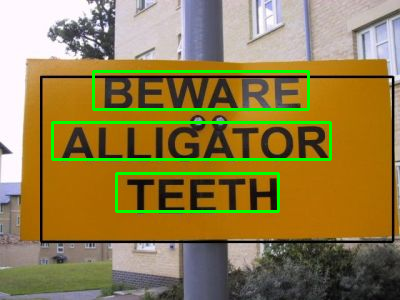

-1

In [64]:

print(img.shape[:2])
rW = oW / float(reqwt)
rH = oH / float(reqht)
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios

    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
    img=cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
cv2_imshow(img)
cv2.waitKey(0)

In [65]:
cv2.imwrite("output.png",img)

True

In [66]:
char_list = string.ascii_letters+string.digits
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)

    return dig_lst

In [67]:


def preprocess(image):
      img= np.array((image))

      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      w, h = img.shape
      #print(w,h)
      if h > 128 :

        img= cv2.resize(img,dsize=(128,w),interpolation=cv2.INTER_NEAREST)
        w,h =img.shape
      if w > 32:
        img= cv2.resize(img,dsize=(h,32),interpolation=cv2.INTER_NEAREST)
        w,h = img.shape
      if w < 32:
        add_zeros = np.ones((32-w, h))*255
        img = np.concatenate((img, add_zeros))

      if h < 128:
        add_zeros = np.ones((32, 128-h))*255
        img = np.concatenate((img, add_zeros), axis=1)
      img = np.expand_dims(img , axis = 2)

      img = img/255.0


      return img

In [68]:
inputs = Input(shape=(32,128,1))

conv1=Conv2D(64,(3,3), activation = 'relu', padding='same')(inputs)
pool1= MaxPool2D(pool_size=(2,2),strides=2)(conv1)

conv2=Conv2D(128,(3,3), activation = 'relu', padding='same')(pool1)
pool2= MaxPool2D(pool_size=(2,2),strides=2)(conv2)

conv3=Conv2D(256,(3,3), activation = 'relu', padding='same')(pool2)
conv4=Conv2D(256,(3,3), activation = 'relu', padding='same')(conv3)
pool4= MaxPool2D(pool_size=(2,1))(conv4)

conv5=Conv2D(512,(3,3), activation = 'relu', padding='same')(pool4)
batchnorm5 = BatchNormalization()(conv5)
conv6=Conv2D(512,(3,3), activation = 'relu', padding='same')(batchnorm5)
batchnorm6 = BatchNormalization()(conv6)

pool6=MaxPool2D(pool_size=(2,1))(batchnorm6)
conv7=Conv2D(512,(2,2), activation = 'relu')(pool6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv7)


# bidirectional LSTM layers with units=128
blstm1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm2)

act_model = Model(inputs, outputs)


In [69]:
labels = Input(name='the_labels', shape=[50], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [70]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    )
callbacks_list = [checkpoint]

In [71]:
import matplotlib.pyplot as plt

-1

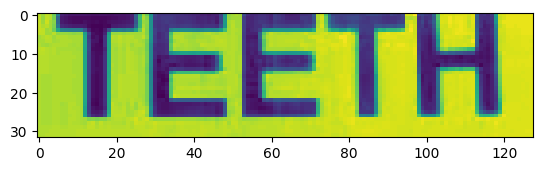

In [72]:
imgarr=[]
rW = oW / float(reqwt)
rH = oH / float(reqht)
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios

    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
    imgarr.append(preprocess(image[startY:endY, startX:endX]))

# show the output image
plt.imshow(imgarr[1])
cv2.waitKey(0)

In [73]:
import tensorflow as tf

In [74]:
# load the saved best model weights
act_model.load_weights('/content/drive/MyDrive/EAST Text Detection/best_model (1).hdf5')

# predict outputs on validation images
imgs_np = tf.reshape(imgarr, [-1, 32, 128, 1])
prediction = act_model.predict(imgs_np)

# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

# see the results
i = 0
for x in out:
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    print('\n')
    i+=1

1/1 [==============================] - 2s 2s/step
predicted text = ALLIGATOR

predicted text = TeErh

predicted text = BEWVARE



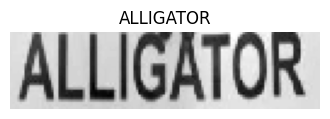

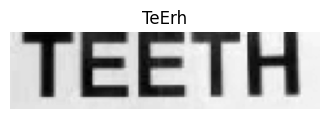

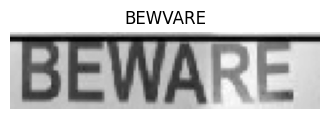

In [75]:
# see the results
z=len(out)
for id,x in enumerate(out):

    str1 = ""
    for p in x:
        if int(p) != -1:
            str1 += char_list[int(p)]
    #plt.subplot(z//2,(z//2)+1,id+1)
    plt.figure(figsize=(4,1))
    plt.imshow(imgarr[id],cmap="gray", aspect="auto")
    plt.title(str1)
    plt.axis('off')
    #print('\n')
